In [ ]:
# getting TC forecast (the connection seems to be down now, but it worked earlier)

In [ ]:
from climada_petals.hazard import TCForecast
import logging
import datetime
import os
import numpy as np
#how to current current tc forecast, the server seems to be down for now

logging.getLogger('climada.hazard.tc_tracks_forecast').setLevel(logging.WARNING)
print("Processing ECMWF forecast. Date: " + str(datetime.datetime.now()))

forecast = TCForecast()
forecast.fetch_ecmwf()

In [ ]:
#this way you can fetch data for past dates
forecast = TCForecast()

target_dir = {}
date_list = ["20230222120000"]
for date in date_list:
    target_dir[date] = os.path.join("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/forecast_data", date)
    if not os.path.exists(target_dir[date]):
        os.makedirs(target_dir[date])
        print(f"Created directory: {target_dir[date]}")
    else:
        print(f"Directory already exists: {target_dir[date]}")
    forecast.fetch_bufr_ftp(target_dir=target_dir[date],remote_dir=date)

In [5]:
# open an event in the tc track forecast class, you need to be able to run the cell above first
tc_fcast = TCForecast()
tc_fcast.fetch_ecmwf("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/forecast_data/20230311120000/")

Processing: 100%|█| 23/23 [00:


In [6]:
# create a climada tc object
from climada.hazard.trop_cyclone import TropCyclone 
tc = TropCyclone.from_tracks(tc_fcast)


In [10]:
#we have several events, and we woul focus only on one at a time
np.unique(tc.event_name)

array(['07S', '70B', '70C', '70E', '70L', '70P', '70S', '70U', '70W',
       '71L', '71P', '71S', '71U', '71W', '72P', '72S', '72U', '72W',
       '73P', '73S', '74P', '75P', '76P'], dtype='<U3')

In [11]:
tc.centroids.set_region_id()
tc_moz = tc.select(reg_id=508) # selecting centroids only over mozambique

<GeoAxes: title={'center': 'TC max intensity at each point'}>

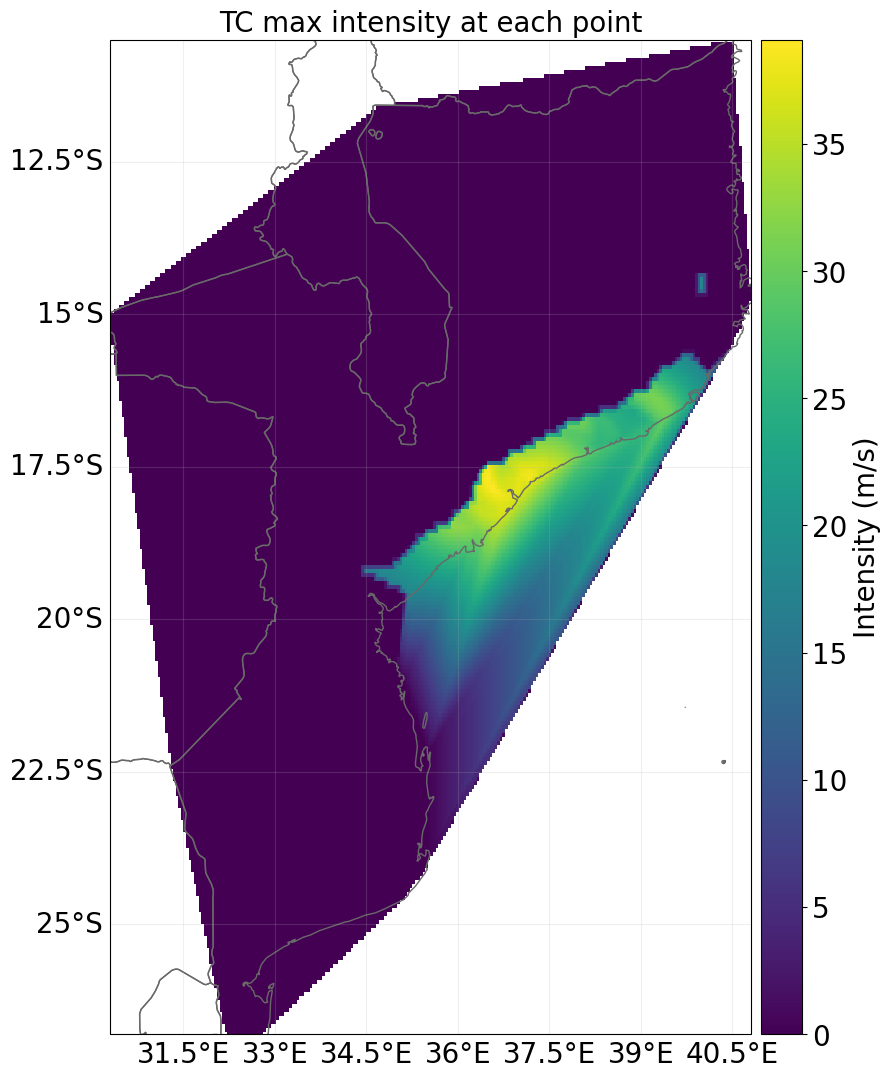

In [12]:
tc_moz.plot_intensity(0)

In [13]:
np.array(tc_moz.event_name)[np.asarray(tc_moz.intensity.sum(axis=1)>0).reshape(-1)]

array(['70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S',
       '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S',
       '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S',
       '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S',
       '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S', '70S',
       '70S', '70S', '70S', '70S', '70S', '70S', '07S', '07S', '07S',
       '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S',
       '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S',
       '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S',
       '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S',
       '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S', '07S',
       '07S', '07S', '07S', '07S', '72S', '71S'], dtype='<U3')

In [15]:
tc_moz = tc_moz.select(event_id=list(tc.event_id[np.array(tc.event_name)=='70S']))

In [17]:
tc_moz.event_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

# Getting infrastructure data

In [30]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import shapely
import os
import pickle
import numpy as np

from scipy.sparse import csr_matrix
from datetime import datetime

# on climada_petals branch feature/networks until merged!
from climada_petals.engine.networks import nw_utils as nwu
from climada_petals.entity.exposures.openstreetmap import osm_dataloader as osm
from climada_petals.util.constants import DICT_GEOFABRIK

# on climada_python develop branch
from climada.util import coordinates as u_coords
from climada.entity.exposures.base import Exposures
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet
from climada.engine import Impact
from climada.hazard.base import Hazard
from climada.util import lines_polys_handler as u_lp
from climada.util.api_client import Client

from climada_petals.entity.exposures.openstreetmap import osm_dataloader as osm
from climada_petals.util.constants import DICT_GEOFABRIK

from climada.util import coordinates as u_coords
from climada.hazard.base import Hazard


In [20]:
# general paths & constants
PATH_DATA = '/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/infrastructure/'
PATH_DATA_OSM = '/Users/szelie/climada/data/openstreetmap/' # path to search for osm.pbf files and to download to if not existing
PATH_DATA_HVMV = PATH_DATA +'power_global/grid.gpkg' # path of this file from gridfinder. needs to be downloaded.
PATH_DATA_PP = PATH_DATA +'power_global/global_power_plant_database.csv' # path of this file from WRI global power plant db. needs to be downloaded.
#PATH_DATA_CT = PATH_DATA +'cell_towers/opencellid_global_1km_int.tif' # path of this file from worldbank open data gridded celltowers. needs to be downloaded.
PATH_DATA_POP = PATH_DATA + 'population/' # path to search for population files and to download to if not existing
PATH_SAVE = '/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/infrastructure/mozambique_results'


In [21]:
cntry = 'Mozambique'
iso3 = u_coords.country_to_iso(cntry)

try:
    path_osm_cntry = PATH_DATA_OSM+DICT_GEOFABRIK[iso3][-1]+'-latest.osm.pbf'
except KeyError:
    path_osm_cntry = PATH_DATA_OSM+f'{cntry}'+'-latest.osm.pbf'
path_worldpop_cntry = PATH_DATA_POP + f'{iso3.lower()}_ppp_2020_1km_Aggregated_UNadj.tif'
path_el_consump_cntry = PATH_DATA + f'power/Electricity consumption per capita - {cntry}.csv'
path_elgen_cntry = PATH_DATA + f'power/Electricity generation by source - {cntry}.csv'
path_el_imp_exp_cntry = PATH_DATA + f'power/Electricity imports vs. exports - {cntry}.csv'
path_save_cntry = PATH_SAVE + f'{iso3}/'
if not os.path.isdir(path_save_cntry):
    os.mkdir(path_save_cntry)


In [22]:
# COUNTRY SHAPE    
__, cntry_shape = u_coords.get_admin1_info([cntry])
cntry_shape = shapely.ops.unary_union([shp for shp in cntry_shape[iso3]])

In [40]:
# POWER LINES
gdf_powerlines = gpd.read_file(PATH_DATA_HVMV, mask=cntry_shape)
gdf_powerlines['osm_id'] = 'n/a'
gdf_powerlines['ci_type'] = 'power_line' 
gdf_powerlines = gdf_powerlines[['osm_id', 'geometry', 'ci_type']]




In [51]:
# POWER PLANTS
# try WRI pp database, then OSM
gdf_pp_world = gpd.read_file(PATH_DATA_PP, crs='EPSG:4326')
gdf_pp = gdf_pp_world[gdf_pp_world.country==f'{iso3}'][
    ['estimated_generation_gwh_2017','latitude','longitude',
     'name']]
del gdf_pp_world
if not gdf_pp.empty:
    gdf_pp = gpd.GeoDataFrame(
        gdf_pp, geometry=gpd.points_from_xy(gdf_pp.longitude, gdf_pp.latitude))
else:
    gdf_pp = CntryFileQuery.retrieve_cis('power')
    if len(gdf_pp[gdf_pp.power=='plant'])>1:
        gdf_pp = gdf_pp[gdf_pp.power=='plant']
    else:
        # last 'resort': take generators frmom OSM
        gdf_pp = gdf_pp[gdf_pp.power=='generator']
    gdf_pp['geometry'] = gdf_pp.geometry.apply(lambda geom: geom.centroid)
    gdf_pp = gdf_pp[['name', 'power', 'geometry']]
gdf_pp['ci_type'] = 'power_plant'


In [31]:
# SUBSTATIONS
CntryFileQuery = osm.OSMFileQuery(path_osm_cntry)
gdf_power = CntryFileQuery.retrieve_cis('power')
gdf_power = gdf_power[[power_type in ['generator','plant','substation','switch', 'transformer'] 
               for power_type in gdf_power.power]]
gdf_power['geometry'] = gdf_power.apply(lambda row: row.geometry.convex_hull.centroid, axis=1)
gdf_power=gdf_power.reset_index(drop=True)

extract points: 100%|█| 28120/
extract multipolygons: 100%|█|
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:434: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(
extract lines: 100%|█| 309/309
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:437: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [32]:
#hospitals
gdf_health = CntryFileQuery.retrieve_cis('healthcare') 
gdf_health['geometry'] = gdf_health.geometry.apply(lambda geom: geom.centroid)
gdf_health = gdf_health[['name', 'geometry']]
gdf_health = gdf_health[gdf_health.geometry.within(cntry_shape)]
gdf_health['ci_type'] = 'health'

extract points: 100%|█| 791/79
extract multipolygons: 100%|█|
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:420: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [33]:
# EDUC. FACILITIES
# from osm
gdf_educ = CntryFileQuery.retrieve_cis('education')
gdf_educ['geometry'] = gdf_educ.geometry.apply(lambda geom: geom.centroid)
gdf_educ = gdf_educ[['name', 'geometry']]
gdf_educ = gdf_educ[gdf_educ.geometry.within(cntry_shape)]


extract points: 100%|█| 226/22
extract multipolygons: 100%|█|
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:420: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [151]:
# # TELECOM, ignore for now
# # cells from rasterized opencellID (via WB)
# path_ct_cntry = path_save_cntry+'celltowers.tif'
# if not Path(path_ct_cntry).is_file():
#     if cntry_shape.type=='Polygon':
#         geo_mask = [cntry_shape]
#     else:
#         geo_mask = [mp for mp in cntry_shape]
#     meta_ct, arr_ct = u_coords.read_raster(PATH_DATA_CT, src_crs={'epsg':'4326'},
#                                            geometry=geo_mask)
#     u_coords.write_raster(path_ct_cntry, arr_ct, meta_ct)
# gdf_cells = nwu.load_resampled_raster(path_ct_cntry, 1/5)

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_92019/3940183040.py:8: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  geo_mask = [mp for mp in cntry_shape]


RasterioIOError: /cluster/work/climate/evelynm/nw_inputs/opencellid_global_1km_int.tif: No such file or directory

In [34]:
# ROADS
# from osm; by default, take all types of roads
gdf_roads = CntryFileQuery.retrieve_cis('road') # for large countries: take main_road only and uncomment later ones
frac_unclass = gdf_roads.groupby('highway').size()['unclassified']/len(gdf_roads)

if frac_unclass < 0.2:
    # if unclassified road fraction is quite small, take only main roads
    gdf_roads = gdf_roads[(gdf_roads.highway != 'residential') & 
                          (gdf_roads.highway != 'unclassified')]

gdf_roads = gdf_roads[gdf_roads.geometry.type=='LineString']
gdf_roads = gdf_roads[['osm_id','highway', 'geometry']]
gdf_roads = gdf_roads[gdf_roads.within(cntry_shape)]


extract points: 0it [00:01, ?it/s]
extract multipolygons: 100%|█|
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:434: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(
extract lines: 100%|█| 276465/
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:437: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [52]:
# give ci_type attribute
gdf_pp['ci_type'] = 'power_plant'
gdf_power['ci_type'] = 'power_component'
gdf_powerlines['ci_type'] = 'power_line'
gdf_health['ci_type'] = 'health'
gdf_educ['ci_type'] = 'education'
# gdf_cells['ci_type'] = 'celltower'
gdf_roads['ci_type'] = 'road'

In [53]:
# save locally to save time
for gdf in [gdf_pp, gdf_power, gdf_powerlines, gdf_health, gdf_educ, gdf_roads]:
    gdf.to_feather(path_save_cntry+f'{gdf.ci_type.iloc[0]}')

In [54]:
# re-load:
gdf_pp = gpd.read_feather(path_save_cntry+'power_plant')
gdf_power = gpd.read_feather(path_save_cntry+'power_component')
gdf_powerlines= gpd.read_feather(path_save_cntry+ 'power_line')
gdf_health= gpd.read_feather(path_save_cntry+ 'health')
gdf_educ= gpd.read_feather(path_save_cntry+'education')
#gdf_cells= gpd.read_feather(path_save_cntry+'celltower')
gdf_roads= gpd.read_feather(path_save_cntry+'road')

In [55]:
def exposure_from_points(gdf, impf_dict):
    # TODO: check why 'FL' tag not taken when read in raster flood file
    exp_pnt = Exposures(gdf)
    exp_pnt.gdf[f'impf_FL'] = getattr(ImpFuncsCIFloodMoz(), impf_dict['FL']).id
    exp_pnt.gdf[f'impf_TC'] = getattr(ImpFuncsCIWindMoz(), impf_dict['TC']).id
    exp_pnt.gdf['value'] = 1
    exp_pnt.set_lat_lon()
    exp_pnt.check()
    return exp_pnt
      
def exposure_from_lines(gdf, impf_dict, res, 
                        disagg_met=u_lp.DisaggMethod.FIX, disagg_val=None):
    exp_line = Exposures(gdf)
    if not disagg_val:
        disagg_val = res
    exp_pnt = u_lp.exp_geom_to_pnt(exp_line, res=res, to_meters=True, 
                                   disagg_met=disagg_met, disagg_val=disagg_val)  
    exp_pnt.gdf[f'impf_FL'] = getattr(ImpFuncsCIFloodMoz(), impf_dict['FL']).id
    exp_pnt.gdf[f'impf_TC'] = getattr(ImpFuncsCIWindMoz(), impf_dict['TC']).id
    exp_pnt.set_lat_lon()
    exp_pnt.check() 
    return exp_pnt

In [57]:
# some impact functions we have used in the past, we will probably have to reconsider
class ImpFuncsCIFloodMoz():

    def __init__(self):
        self.tag = 'FL'
        self.road = self.step_impf()
        self.power_line = self.no_impf()
        self.power_plant = self.no_impf()
        self.power_component = self.step_impf()
        self.health_level1 = self.health_level_1_impf()
        self.health_level_2_4 = self.health_level_2_4_impf()
        self.education = self.health_level_1_impf()
        self.celltower = self.no_impf()

    def health_level_1_impf(self):
        step_impf = ImpactFunc()
        step_impf.id = 1
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 1])
        step_impf.mdd = np.array([0, 0.81])
        step_impf.paa = np.sort(np.linspace(1, 1, num=2))
        step_impf.check()
        return step_impf

    def health_level_2_4_impf(self):
        step_impf = ImpactFunc()
        step_impf.id = 2
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 1])
        step_impf.mdd = np.array([0, 0.65])
        step_impf.paa = np.sort(np.linspace(1, 1, num=2))
        step_impf.check()
        return step_impf

    def step_impf(self):
        step_impf = ImpactFunc()
        step_impf.id = 3
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 0.95, 0.955, 1])
        step_impf.mdd = np.array([0, 0, 1, 1])
        step_impf.paa = np.sort(np.linspace(1, 1, num=4))
        step_impf.check()
        return step_impf
    
    def no_impf(self):
        no_impf = ImpactFunc() 
        no_impf.id = 4
        no_impf.haz_type = 'FL'
        no_impf.name = 'No impact function flood'
        no_impf.intensity_unit = ''
        no_impf.intensity = np.array([0, 1])
        no_impf.mdd =       np.array([0, 0])
        no_impf.paa =       np.sort(np.linspace(1, 1, num=2))
        no_impf.check()
        return no_impf
    
    
class ImpFuncsCIWindMoz():
    
    def __init__(self):
        self.tag = 'TC'
        self.road = self.road_impf()
        self.power_line = self.pl_impf()
        self.power_tower = self.pt_impf()
        self.power_component = self.no_impf()
        self.power_plant = self.no_impf()
        self.celltower = self.tele_impf()
        self.people = self.people_impf()
        self.education = self.health_level_1_4_impf()
        self.health = self.health_level_1_4_impf()

    def health_level_1_4_impf(self):
        impf_health_1_4 = ImpactFunc()
        impf_health_1_4.id = 2
        impf_health_1_4.haz_type = 'FL'
        impf_health_1_4.name = 'Step function flood'
        impf_health_1_4.intensity_unit = 'm/s'
        impf_health_1_4.intensity = np.array([12, 18, 20, 40, 50, 60, 70, 90])
        impf_health_1_4.mdd = np.array([0, 0.03, 0.3, 0.5, 0.6, 0.61, 0.61, 0.61])
        impf_health_1_4.paa = np.ones(impf_health_1_4.intensity.shape)
        impf_health_1_4.check()
        return impf_health_1_4
        
    def road_impf(self):
        # Road adapted from Koks et al. 2019 (tree blowdown on road > 42 m/s)
        impf_road = ImpactFunc() 
        impf_road.id = 2
        impf_road.haz_type = 'TC'
        impf_road.name = 'Loss func. for roads from tree blowdown'
        impf_road.intensity_unit = 'm/s'
        #impf_road.intensity = np.array([0, 30, 35, 42, 48, 120])
        impf_road.intensity = np.array([0, 20, 40, 42, 44, 120])
        impf_road.mdd =       np.array([0, 0,   0, 50, 100, 100]) / 100
        impf_road.paa = np.sort(np.linspace(1, 1, num=6))
        impf_road.check()
        return impf_road
    
    def p_fail_powertower(self, v_eval, L=97.2, x0=77.8, k=0.3):
        """
        adapted from https://arxiv.org/abs/2107.06072 Fragility curves for power transmission towers in
        Odisha, India, based on observed damage during 2019 Cyclone Fani; based on functionality disruption curve
        """
        p_fail = []
        for v in v_eval:
            p_fail.append(L/(1 + np.exp(-k * (v-x0)))/100)
                          
        return p_fail
    
    def pt_impf(self):
        # Power tower impact function 
        v_eval = np.linspace(0, 120, num=120)
        p_fail_powertower = self.p_fail_powertower(v_eval, L=97.2, x0=77.8, k=0.3)
        impf_pt = ImpactFunc() 
        impf_pt.id = 8
        impf_pt.haz_type = 'TC'
        impf_pt.name = 'Disruption func. for power towers from strong winds'
        impf_pt.intensity_unit = 'm/s'
        impf_pt.intensity = np.array(v_eval)
        impf_pt.mdd = np.array(p_fail_powertower)
        impf_pt.paa = np.sort(np.linspace(1, 1, num=120))
        impf_pt.check()
        return impf_pt
        
    def no_impf(self):
        impf_none = ImpactFunc() 
        impf_none.id = 6
        impf_none.haz_type = 'TC'
        impf_none.name = 'No-impact func'
        impf_none.intensity_unit = 'm/s'
        impf_none.intensity = np.array([0,  140])  
        impf_none.mdd =       np.array([0, 0 ])         
        impf_none.paa = np.sort(np.linspace(1, 1, num=2))
        impf_none.check()
        return impf_none

    def tele_impf(self):
        # adapted from newspaper articles ("cell towers to withstand up to 110 mph")
        impf_tele = ImpactFunc() 
        impf_tele.id = 3
        impf_tele.haz_type = 'TC'
        impf_tele.name = 'Loss func. cell tower'
        impf_tele.intensity_unit = 'm/s'
        impf_tele.intensity = np.array([0,  80, 100, 120, 260]) / 2.237
        impf_tele.mdd =       np.array([0,  0, 100,  100,  100]) / 100
        impf_tele.paa = np.sort(np.linspace(1, 1, num=5))
        impf_tele.check()
        return impf_tele
   
    def p_fail_pl(self, v_eval, v_crit=30, v_coll=60):
        """
        adapted from  https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7801854
        and Vulnerability Assessment for Power Transmission Lines under Typhoon 
        Weather Based on a Cascading Failure State Transition Diagram
        """
        p_fail = []
        for v in v_eval:
            p = 0
            if (v > v_crit) & (v < v_coll):
                p = np.exp(0.6931*(v-v_crit)/v_crit)-1
            elif v > v_coll:
                p = 1
            p_fail.append(p)
        return p_fail
    
    def pl_impf(self, v_crit=30, v_coll=60):
        # Power line
        v_eval = np.linspace(0, 120, num=120)
        p_fail_powerlines = self.p_fail_pl(v_eval, v_crit=v_crit, v_coll=v_coll)
        impf_prob = ImpactFunc() 
        impf_prob.id = 1
        impf_prob.tag = 'PL_Prob'
        impf_prob.haz_type = 'TC'
        impf_prob.name = 'power line failure prob'
        impf_prob.intensity_unit = 'm/s'
        impf_prob.intensity = np.array(v_eval)
        impf_prob.mdd = np.array(p_fail_powerlines)
        impf_prob.paa = np.sort(np.linspace(1, 1, num=120))
        impf_prob.check()
        return impf_prob
    
    def people_impf(self):
        # Mapping of wind field >= hurricane scale 1 (33 m/s)
        impf_ppl = ImpactFunc() 
        impf_ppl.id = 7
        impf_ppl.haz_type = 'TC'
        impf_ppl.name = 'People - Windfield Mapping >= TC'
        impf_ppl.intensity_unit = 'm/s'
        impf_ppl.intensity = np.array([0, 32, 33, 80, 100, 120, 140, 160]) 
        impf_ppl.mdd = np.array([0, 0,   100,  100,   100,  100,  100,  100]) / 100
        impf_ppl.paa = np.sort(np.linspace(1, 1, num=8))
        impf_ppl.check()
        return impf_ppl

    def binary_impact_from_prob(self, probs_fail, seed=47):
        np.random.seed = seed
        rand = np.random.random(probs_fail.size)
        return np.array([1 if p_fail > rnd else 0 for p_fail, rnd in 
                         zip(probs_fail, rand)])       



In [58]:
exp_health = exposure_from_points(gdf_health, {'FL': 'health_level1', 'TC': 'health'})
exp_educ = exposure_from_points(gdf_educ, {'FL': 'education', 'TC': 'education'})
#exp_celltowers = exposure_from_points(gdf_cells, {'FL': 'celltower', 'TC': 'celltower'})
exp_pplant = exposure_from_points(gdf_pp, {'FL': 'power_plant', 'TC': 'power_plant'})
exp_pcomps = exposure_from_points(gdf_power, {'FL': 'power_component', 'TC': 'power_component'})
exp_pline = exposure_from_lines(gdf_powerlines, {'FL': 'power_line', 'TC': 'power_line'}, res=500)
exp_ptower = exposure_from_lines(gdf_powerlines, {'FL': 'power_line', 'TC': 'power_tower'}, res=500, disagg_val=1)
exp_road = exposure_from_lines(gdf_roads, {'FL': 'road', 'TC': 'road'}, res=500)

In [59]:
def make_impfset(imp_class):
    impfset = ImpactFuncSet()
    for attribute in set(imp_class.__dict__.keys()).difference({'tag'}):
        impfset.append(getattr(imp_class, attribute))
    return impfset

In [60]:
impf_set_tc = make_impfset(ImpFuncsCIWindMoz())

# Impact calculation

In [61]:
# Wind-field impacts - Points
imp_tc_health = Impact()
imp_tc_health.calc(exp_health, impf_set_tc, tc_moz)
imp_tc_educ = Impact()
imp_tc_educ.calc(exp_educ, impf_set_tc, tc_moz)
# imp_tc_cell = Impact()
# imp_tc_cell.calc(exp_celltowers, impf_set_tc, tc_moz)
imp_tc_pcomp = Impact()
imp_tc_pcomp.calc(exp_pcomps, impf_set_tc, tc_moz)
imp_tc_pplant = Impact()
imp_tc_pplant.calc(exp_pplant, impf_set_tc, tc_moz)

2023-05-15 08:29:54,350 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-05-15 08:29:54,367 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-05-15 08:29:54,376 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-05-15 08:29:54,390 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [62]:
# Wind-field impacts - Lines

# Power lines (lines)
imp_tc_pline = Impact()
orig_res = exp_pline.gdf.value.values[0] #this works only if all values the same!
exp_pline.gdf['value'] = 1
imp_tc_pline.calc(exp_pline, impf_set_tc, tc_moz, save_mat=True)
imp_tc_pline.imp_mat.data = ImpFuncsCIWindMoz().binary_impact_from_prob(imp_tc_pline.imp_mat.data)*orig_res
exp_pline.gdf['value'] = orig_res
# Power lines (towers)
imp_tc_ptower = Impact()
imp_tc_ptower.calc(exp_ptower, impf_set_tc, tc_moz, save_mat=True)
imp_tc_ptower.imp_mat.data = ImpFuncsCIWindMoz().binary_impact_from_prob(imp_tc_ptower.imp_mat.data)*orig_res
# Total Power lines
imp_tc_pline.imp_mat+=imp_tc_ptower.imp_mat
imp_tc_pline = u_lp.impact_pnt_agg(imp_tc_pline,  exp_pline.gdf, u_lp.AggMethod.SUM) 

2023-05-15 08:29:54,403 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-05-15 08:29:54,568 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 34489 coordinates.
2023-05-15 08:29:54,588 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-05-15 08:29:54,752 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 34489 coordinates.
2023-05-15 08:29:54,760 - climada.hazard.base - WARNING - Impact function id=8 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


In [63]:
imp_tc_road = Impact()
imp_tc_road.calc(exp_road, impf_set_tc, tc_moz, save_mat=True)
imp_tc_road = u_lp.impact_pnt_agg(imp_tc_road,  exp_road.gdf, u_lp.AggMethod.SUM)

2023-05-15 08:29:56,658 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
